<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Images-from-Data-Set" data-toc-modified-id="Loading-Images-from-Data-Set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Images from Data Set</a></span></li><li><span><a href="#Define-a-Convolutional-Neural-Network" data-toc-modified-id="Define-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define a Convolutional Neural Network</a></span></li><li><span><a href="#Training-the-Network" data-toc-modified-id="Training-the-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training the Network</a></span></li><li><span><a href="#Testing-the-Network" data-toc-modified-id="Testing-the-Network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the Network</a></span></li><li><span><a href="#Improving-the-Network" data-toc-modified-id="Improving-the-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Improving the Network</a></span></li></ul></div>

# CNN for Classification of Small Images (CIFAR 10 dataset)

This notebook is an adaptation of a demo notebook in the Pytorch documentation. Please be patient while running the code in the notebook. I haven't used any GPU that might be available on your computer. Training on my computer takes more than a minute (yes not too fast...).

In order to run the code you need to install pytorch on your system. The modules `torch` and `torchvision` should be installed.

The [PyTorch](https://pytorch.org/) website is invaluable for understanding the code in this notebook. And it is a great source for further exploration of modern Machine Learning.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


## Loading Images from Data Set

PyTorch has some well known data sets 'build in', among others the CIFAR data set. Below we (download and) read in the data set. In the process of defining the train and test set PyTorch allows us to transform the images on the fly. In this case we only convert the PIL image to a tensor (the basic PyTorch data structure comparable with the ndarray in numpy) and we normalize the image (by subtracting 0.5 from each rgb value in the image and dividing by 0.5, as each image has rgb values in the range from 0 to 1 we end up with values in the range from -1 to +1). Normalization of the data is important in any neural network.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 8
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


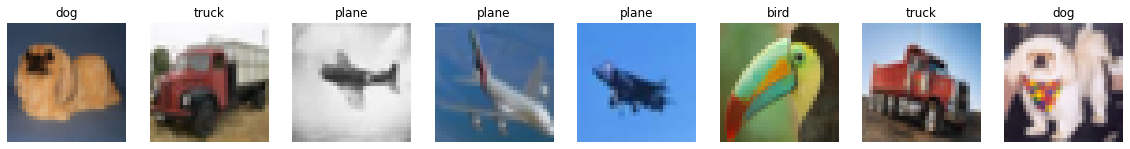

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imlabelshow(imgs, lbls):
    fig, axs = plt.subplots(1, len(imgs), figsize=(20,5))
    for i, (im, label) in enumerate(zip(imgs, labels)):
        im = im / 2 + 0.5 # unnormalize
        axs[i].imshow(np.transpose(im.numpy(),(1,2,0)))
        axs[i].set_title(classes[label])
        axs[i].axis('off')
        
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imlabelshow(images, labels)


**Questions**
1. If you would be random guessing the class of an image what would be the expected accuracy of the 'classifier'?

## Define a Convolutional Neural Network

We define the following CNN to classify the CIFAR images.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In a data flow graph the first part of this network looks like
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/cifar_cnn_incomplete.png"
     width=50%
     alt="data flow graph"
     style="float: center;" />
The CIFAR images are 32x32 color images, so $W_1 = H_1 = 32$ and $C_1 = 3$. 

**Questions.**
1. Complete the data flow graph. For each of data block (image blocks at the start and flattened arrays at the end) you should indicate the shape of the block. Either you should look into the documentation of the processing modules that are being used in the `__init__` function or you should run the code and print the shapes (when we are running/training the network).

2. In the `__init__` function the following processing modules are defined: `conv1`, `pool`, `conv2`, `fc1`, `fc2` and `fc3`. Indicate where these modules are used in your data flow graph.

To train the network we also need to define a loss function and optimizer method:

In [30]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

here `lr` is the learning rate. The momentum is also used in the gradient descent procedure to 'remember' in which direction the gradient descent is running and not deviate too much from that direction.

Note that while constructing the network (in the `__init__` function and `forward` function) Pytorch keeps track of all parameters in the processing modules that are used and it collects these parameters in a list that is given with the `net.parameters()` function.

## Training the Network

In [61]:
%%time
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.074
[1,  4000] loss: 1.079
[1,  6000] loss: 1.061
[2,  2000] loss: 1.013
[2,  4000] loss: 1.000
[2,  6000] loss: 1.016
Finished Training
CPU times: user 8min 32s, sys: 38.6 s, total: 9min 11s
Wall time: 1min 9s


In [36]:
# Uncomment the following 2 lines to save your network to file
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)
#
# when saved you can load it back into memory with
# (again uncomment the following 2 lines)
# net = Net()
# net.load_state_dict(torch.load(PATH))

We load some images from the test set, display these image with their ground truth label. 

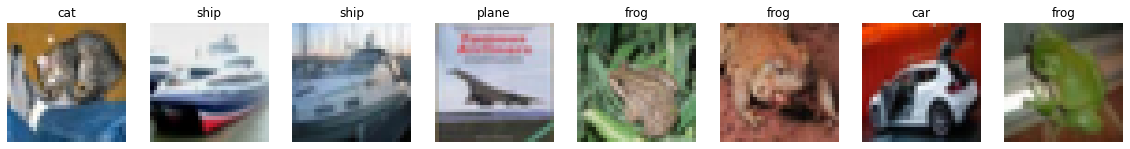

In [44]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imlabelshow(images, labels)

Then we run these image through the network and print the outputs of the 10 output nodes for all images. Note that now we are not training the network Pytorch doesn't need to keep track of all the intermediate outputs of all modules in the network (in preparation of a backward pass) and we can tell Pytorch not to do that with `no_grad()`.

In [74]:
with torch.no_grad():
    outputs = net(images)
print(outputs)

tensor([[-3.0449, -2.4087,  0.4942,  5.5662,  0.0767,  3.8527,  1.9214,  0.6245,
         -1.4920, -2.5234],
        [-0.9129, -1.6228, -1.4664,  2.9551, -2.1793,  4.7203, -3.1039,  1.2666,
          1.1019,  0.1403],
        [-2.4299, -2.3173,  1.0847,  4.7915,  2.5101,  2.5439,  2.3619, -1.6380,
         -0.1170, -3.6389],
        [-0.1646, -3.5759, -0.6140,  4.0127,  0.4465,  4.4445, -1.7853,  0.3094,
          0.2289, -2.7864],
        [-3.9783, -3.4555,  1.4012,  4.7474,  2.2071,  4.1897,  4.6630,  0.6678,
         -4.0634, -3.5897],
        [-2.4927, -3.6332,  1.0879,  4.0751, -0.4030,  5.9750, -1.3068,  1.8152,
         -1.1634, -2.4546],
        [ 0.6597,  2.3788,  1.1258,  1.3583,  1.5104,  0.8050, -1.5786,  1.1282,
         -1.8232, -1.6887],
        [-2.2236, -4.2628,  1.1916, -1.2503,  5.8938,  1.7213, -2.0109,  8.3692,
         -4.4165, -3.3488]])


The predicted label will be the label with the largest output value.

In [51]:
maxvalue, maxindex = torch.max(outputs, 1)
print('True     : ', ' '.join('%10s' % classes[labels[j]]
                              for j in range(batch_size)))
print('Predicted: ', ' '.join('%10s' % classes[maxindex[j]]
                              for j in range(batch_size)))

True     :         cat       ship       ship      plane       frog       frog        car       frog
Predicted:         cat      plane       ship      plane       deer       frog        dog       bird


The prediction is certainly better than simple guessing (but far from ideal).

## Testing the Network

In [65]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 61.34%


**Questions.**
1. Make the confusion matrix for this classifier to see how well the classifier does for the different classes.

## Improving the Network

Selecting a network architecture for a CNN is more of an art then a science. Simple experimenting with different no of channels, with different number of (convolution) layers can sometimes improve your network.

**Questions.**
1. The obvious way to start improving your network is by training for more epochs. Only 2 epochs is really not much (but you need a fast computer or a GPU or a lot of patience).
1. Change the number of channels in the first data (image) block after the input image (a block with 3 channels) to 20 and train and run the network again. Does it improve the performance?

1. Insert a new convolution layer at the start (with activation function!). 

Note that changing the network architecture is not a trivial exercise as a change in one of the processing modules will influence other modules further down the stream.